# Supernova H5 Notebook 
This notebook aims to plot different properties such as temperature and density throughout a pre supernova and post supernova star using HDF5 files. 

In addition it will look look at the abundances of different isotopes in pre and post supernova stars.

## Getting the data

First we obtain the H5 file, which contains data on the presupernova star, the individual zones during the supernova, and the post explosion star: 

In [5]:
import sys
import gzip
!curl -o out.h5.gz -J -L https://osf.io/73zd2/download
!gunzip out.h5.gz
!{sys.executable} -m pip install --quiet wnutils

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   459  100   459    0     0   1705      0 --:--:-- --:--:-- --:--:--  1719

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0  369M    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0  369M    0 1988k    0     0   604k      0  0:10:26  0:00:03  0:10:23  666k
  1  369M    1 4100k    0     0   956k      0  0:06:36  0:00:04  0:06:32 1029k
  1  369M    1 6452k    0     0  1218k      0  0:05:10  0:00:05  0:05:05 1292k
  2  369M    2 8132k    0     0  1290k      0  0:04:53  0:00:06  0:04:47 1632k
  2  369M    2 10.2M    0     0  1436k      0  0:04:23  0:00:07  0:04:16 2101k
  3  369M    3 12.7M    0     0  1574k      0  0:0


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Then, we import the h5 wnutils package and read in the h5 file to the program. 

In [6]:
import wnutils.h5 as w5
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation as anim
h5=w5.H5('out.h5')

OSError: Unable to open file (unable to open file: name = 'out.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In an h5 file, the data is separated into groups. To see the groups you can type:

In [ ]:
it_groups = h5.get_iterable_groups()
print(it_groups)

And to get the properties in each group:

In [ ]:
for groups in it_groups:
    print(groups: h5.get_group_zone_properties(groups, "[position = last()]"))

Now, one can modify the below code to save the properties of interest to them. For the pre and post supernova, the properties are not time dependant and are functions of the interior lagrangian mass coordinate. For the explosion run group, all properties are functions of time.

In [ ]:
#Zone '200' vs. time during shockwave propagation, to vary the zone just change 'Expl/Runs/#' to the zone # of interest
props_run=h5.get_group_properties_in_zones_as_floats('Expl/Runs/200',['time','t9','rho'])

#Post supernova star (After shockwave propogation)
props_postsn=h5.get_group_properties_in_zones_as_floats('Expl/Full',['t9','shock t9','t9_0','mass below','shock time'])

Next, we obtain the mass fractions for the given species in each group. Isotopes are specified by the format: 'symbolA', where symbol is the element symbol and A is the mass number of the isotope. Here we look at $^{15}$N and $^{18}$O, but the species list can be modified to whatever species are of interest to you:

In [ ]:
species = ['n15','o18']

#mass fractions in zone '200' vs. time during shockwave propagation
mfracs_run=h5.get_group_mass_fractions('Expl/Runs/200')

### Functions 

The following are two functions that will be used later in the program, one for creating the animation of the shockwave and the other for plotting mass fractions throughout stars. 

In [ ]:
#function for animating the shockwave
#Argument: 
#     props - dict of post supernova properties includeint 't9','t9_0','shock t9', and 'mass below'
def make_shock_anim(props):
  from IPython.display import HTML
  from matplotlib.animation import FuncAnimation

  #x - constant, will be the 'mass below' value throughout the star
  #y - varies, contains the temperature of each zone throughout the star at each time step during the propagation of the shock
  x=[]
  y=[]

  #build the x array
  for m in range(len(props_postsn['mass below'])):
    x.append(props_postsn['mass below'][m]/1.9891e33)

  #populate y with initial temperatures 
  for t in props_postsn['t9_0']:
    y.append(t)

  #create a figure for the animation to be written on
  fig,ax=plt.subplots()
  ax.set_xlim([1.4,8])
  ax.set_ylim([-1,9])
  ax.set_xlabel('Mass Below')
  ax.set_ylabel('Temperature ($10^9$K)')
  line, =ax.plot(x,y)


  n_tot = len(props_postsn['shock time'])
  i=np.linspace(0,n_tot-1,n_tot)


  #the function that changes zone temperatures for each time step (animates the plot)
  def shockmovie(t):
    i=int(t)
    y[i]=props_postsn['shock t9'][i]
    for j in range(0,i):
      y[j]=props_postsn['shock t9'][i]
    line.set_xdata(x)
    line.set_ydata(y)
    return line,

  animation=FuncAnimation(fig, func=shockmovie, frames=i, interval=40)
  display(HTML(animation.to_jshtml()))
  plt.close()


#function for plotting isotopic ratios 
#Arguments: 
#    num - the numerator isotope (str) 
#    den - is the denominator isotope (str)
def plot_pre_post_ratios(num,den):

  mfrac=[num,den] 
  ind={}
  for sp in mfrac:
    ind[sp]=(h5.get_nuclide_data())[sp]['index']
  lanames=h5.get_latex_names(mfrac)
  #Calculate the isotopic ratios 
  pre_sn_frac=mass_fractions[:,ind[mfrac[0]]]/mass_fractions[:,ind[mfrac[1]]]
  post_sn_frac=full_mfracs[:,ind[mfrac[0]]]/full_mfracs[:,ind[mfrac[1]]]

  plt.plot(props_postsn['mass below']/1.9891e33,pre_sn_frac,label='Pre Supernova')
  plt.plot(props_postsn['mass below']/1.9891e33,post_sn_frac,label='Post Supernova')
  plt.yscale('log')
  plt.xlabel('Mass Below')
  plt.ylabel(lanames[mfrac[0]] +'/' + lanames[mfrac[1]])
  plt.legend()
  plt.xlim([1.4,10])
  plt.show()

### Plotting a property vs. interior mass coordinate (Pre-supernova star)

The following pulls data from the props_presn dictionary to plot the temperature and density vs. interior mass coordinate in a pre-supernova star:

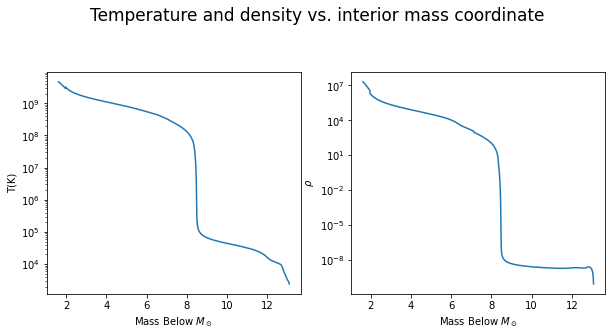

In [ ]:
h5.plot_group_properties_vs_property('PreSn/Full', 'mass below', ['t9','rho'],
                                     xfactor = 1.989e33, 
                                     yscale = 'log',
                                     xlabel = 'Mass Below ($M_\odot$)'
                                    )

###Plot mass fractions vs. interior mass coordinate (Pre-supernova star)

Now we will plot the mass fraction of isotopes of interest throughout the pre-supernova star. The isotopes of interest should have been defined earlier in the 'getting the data' section of this notebook. The following plots the mass fraction vs. interior mass coordinate. 

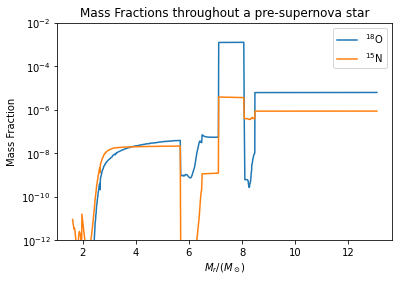

In [ ]:
h5.plot_group_mass_fractions_vs_property('PreSn/Full','mass below', sp, 
                                         yscale = 'log',
                                         xfactor = 1.989e33,
                                         use_latex_names = True,
                                         xlabel = 'Mass Below ($M_\odot$)',
                                         ylabel = 'Mass Fraction')

### Plotting supernova quantities during shockwave propagation

The following looks at one zone of the star during the propagation of the shockwave throughout the star. To plot the temperature vs. time:

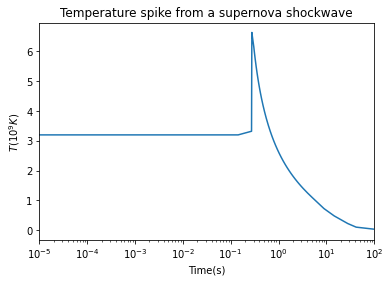

In [ ]:
plt.plot(props_run['time'],props_run['t9'])
plt.xscale('log')
plt.xlim([1e-5,100])
plt.xlabel('Time(s)')
plt.ylabel('$T(10^9K)$')
plt.title('Temperature spike from a supernova shockwave')
plt.show()

Next we want to examine how the abundance of isotopes change in a zone of the star as a result of the supernova shockwave:

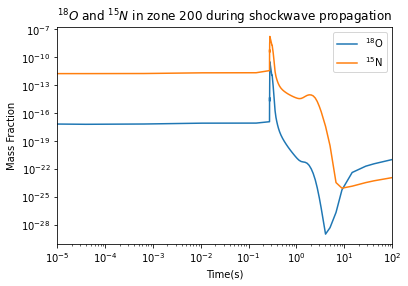

In [ ]:
for sp in species:
  plt.plot(props_run['time'],mfracs_run[:,indices[sp]],label=lnames[sp])
plt.xlabel('Time(s)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Mass Fraction')
plt.xlim([1e-5,100])
plt.title('$^{18}O$ and $^{15}N$ in zone 200 during shockwave propagation')
plt.legend()
plt.show()

##Animating the shockwave

We simply need to call the function make_shock_anim with the post supernova properties to animate the shockwave throughout the star 

In [ ]:
make_shock_anim(props_postsn)

### Plotting properties post supernova

In [ ]:
h5.plot_group_properties_vs_property('PostSn/Full', 'mass below', ['t9','rho'],
                                     xfactor = 1.989e33, 
                                     yscale = 'log',
                                     xlabel = 'Mass Below ($M_\odot$)'
                                    )

### Plotting mass fractions vs. interior mass coordinate post supernova

In [ ]:
h5.plot_group_mass_fractions_vs_property('PostSn/Full','mass below', sp, 
                                         yscale = 'log',
                                         xfactor = 1.989e33,
                                         use_latex_names = True,
                                         xlabel = 'Mass Below ($M_\odot$)',
                                         ylabel = 'Mass Fraction')

##Plotting isotopic ratios pre and post supernova

To examine how an isotopic ratio changes vs. interior mass unit for both the pre and post supernova simply call the function 'plot_pre_post_ratios' with the arguments being the numerator and denominator isotope. 

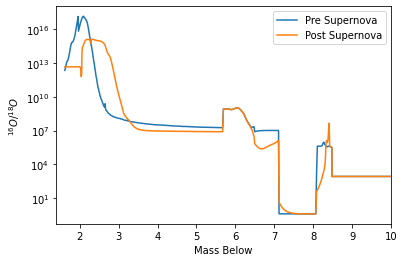

In [ ]:
plot_pre_post_ratios('o16','o18')